## Aqueous solubility prediction based on physical descriptors

Delaney's work to calculate the aqueous solubility, $S (mol/l)$, uses four descriptors: $logP$, $MW$, $RB$, and $AP$. The $logP$ is the decimal logarithm of the octanol/water partition coefficient. It is a measure of the relative affinity of the compound for hydrophobic/aqueous solvents. It depends on the polarity of the compound. The $MW$ is the molecular weight of the compound. $RB$ is the number of the rotatable bonds of the compound. It is a measure of the compound entropic propensity to follow the solvent water molecules. The $AP$ is the aromatic proportion, the ratio between the number of compound's aromatic atoms and the number of heavy atoms.

\begin{equation*}
LogS = C_0 + C_1 LogP + C_2 MW + C_3 RB + C_4 AP
\end{equation*}

where the $LogS$ is the decimal logarithm of the compound's aqueous solubility. 

This notebook is based on [Chanin Nantasenamat's](https://towardsdatascience.com/how-to-use-machine-learning-for-drug-discovery-1ccb5fdf81ad) work.

In [1]:
# Download the Delaney's dataset
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2020-11-26 19:28:09--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.01s   

2020-11-26 19:28:10 (3.94 MB/s) - ‘delaney.csv’ saved [58889/58889]



In [2]:
# import the necessqary libraries
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import pickle

In [3]:
# read the dataset
sol = pd.read_csv('delaney.csv')

In [4]:
# define the rdkit molecular objects
mol_list= []
for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [5]:
# Create a function to calculate LogP, MW and RB descriptors
def generate(smiles, verbose=False):
    """
    This function calculates the first three molecular descriptors, octanol/water partition coefficient,
    molecular weight, and the number of rotatable bonds using the rdkit library and the SMILES structure as inputs
    
    The input argument, smiles, is the SMILES string chemical representation of a molecule
    """

    # convert the SMILES string to rdkit object
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    # calculate the first three molecular descriptors: octanol/water partition coefficient (LogP),
    # molecular weight (Mw), and the number of rotatable bonds (NRb)
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
        
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        # put the three descriptors on a row of an numpy array
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    # rename the header names
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [6]:
# Calculate LogP, MW and RB descriptors
df = generate(sol.SMILES)

In [7]:
def AromaticAtoms(m):
    """
    This function calculates the number of aromatic atoms in a molecule
    The input argument, m, is a rdkit molecular object
    """
    
    aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aa_count = []
    for i in aromatic_atoms:
        if i==True:
            aa_count.append(1)
        
    sum_aa_count = sum(aa_count)
    
    return sum_aa_count

In [8]:
# Compute the aromatic proportion (AP) descriptor
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]

df_desc_AromaticProportion = pd.DataFrame(data=desc_AromaticProportion, columns=["AromaticProportion"]) 

In [9]:
#Create the X matrix by combining the 2 dataframes associated to the four descriptors
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
#X

In [10]:
# Create the Y matrix
Y = sol.iloc[:,1]
print(Y.shape)

(1144,)


In [11]:
# Create the XY matrix (for comparison, mainly)
XY = pd.concat([X,Y], axis=1)
XY.columns = ['MolLogP', 'MolWt', 'NumRotatableBonds', 'AromaticProportion', 'MeasuredLogSol']
XY.head()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,MeasuredLogSol
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00
2,2.5938,167.850,1.0,0.0,-1.74
3,2.0289,133.405,1.0,0.0,-1.48
4,2.9189,187.375,1.0,0.0,-3.04


In [12]:
# Split the dataset into training and validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [13]:
# Train a linear regression model with the train dataset
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

Y_pred_train = model.predict(X_train)

print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'% mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y_train, Y_pred_train))


Coefficients: [-0.74232263 -0.00651158  0.00580964 -0.36984875]
Intercept: 0.22772834271698095
Mean squared error (MSE): 1.05
Coefficient of determination (R^2): 0.76


In [14]:
# Predict the LogS value of X_val data
Y_pred_val = model.predict(X_val)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'% mean_squared_error(Y_val, Y_pred_val))
print('Coefficient of determination (R^2): %.2f'% r2_score(Y_val, Y_pred_val))

Coefficients: [-0.74232263 -0.00651158  0.00580964 -0.36984875]
Intercept: 0.22772834271698095
Mean squared error (MSE): 0.86
Coefficient of determination (R^2): 0.82


### Deriving the Linear Regression Equation based on the full dataset

In [15]:
model = linear_model.LinearRegression()
model.fit(X, Y)

LinearRegression()

In [16]:
Y_pred = model.predict(X)

print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'% mean_squared_error(Y, Y_pred))
print('Coefficient of determination (R^2): %.2f'% r2_score(Y, Y_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [17]:
# calculate the intercept, C0
model_yintercept = '%.2f' % model.intercept_

# calculate the coefficient of the log oil/water partition coefficient descriptor
model_LogP = '%.2f LogP' % model.coef_[0]

# calculate the coefficient of the molecular weight descriptor 
model_MW = '%.4f MW' % model.coef_[1]

# calculate the coefficient of the number of rotatable bonds descriptor
model_RB = '+ %.4f RB' % model.coef_[2]

# calculate the coefficient of the aromatic proportion descriptor
model_AP = '%.2f AP' % model.coef_[3]

# print the equation
print('LogS = ' + 
      ' ' + 
      model_yintercept + 
      ' ' + 
      model_LogP + 
      ' ' + 
      model_MW + 
      ' ' + 
      model_RB + 
      ' ' + 
      model_AP)

LogS =  0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


###  Plot of  predicted vs. experimental LogS

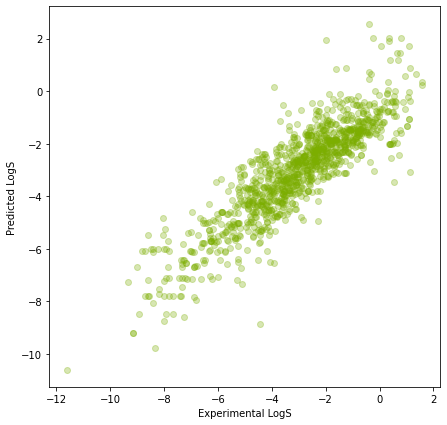

In [18]:
plt.figure(figsize=(7,7))

plt.scatter(x=Y, y=Y_pred, c="#7CAE00", alpha=0.3)

plt.xlabel('Experimental LogS')
plt.ylabel('Predicted LogS')
plt.show()

### Save the model

In [19]:
# save the model
pickle.dump(model, open('model_desc_delaney.pkl', 'wb'))